# Classification using Shallow Neural Network in PySpark.

Pyspark implementation of Shallow Neural Network from scratch using MNIST.

The goal of this project is to use Spark to build a 3 layer Neural Network from Scratch, using my own mathematical formulas to solve an Image classification Task. I will use the very famous MNIST dataset

<strong>We will perform both Binary Classification and Multi Class Classification using the same dataset

# Dataset Preparation

In [1]:
import numpy as np
import os

import sys
import pyspark
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

from pyspark import SparkContext as sc

print("Pyspark Script:", sys.argv[0])
print("PySpark version:", pyspark.__version__)

from keras.datasets import mnist
from keras.utils import to_categorical

# Initialize SparkContext
sc = sc.getOrCreate()

Pyspark Script: /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py
PySpark version: 3.5.1


2025-07-25 20:27:27.142595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753475247.401044      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753475247.479570      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/25 20:27:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
print('Start downloading dataset...')
# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Start downloading dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
print("Training Samples: ", x_train.shape)
print("Testing Samples: ", x_test.shape)

Training Samples:  (60000, 28, 28)
Testing Samples:  (10000, 28, 28)


In [4]:
# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train).reshape(-1, 10)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = to_categorical(y_test)

In [5]:
# To save the CSV data

if not os.path.exists('data/'):
    os.makedirs('data/')


np.savetxt('data/mnist_images_train.csv', x_train.reshape(len(x_train),784).tolist())
np.savetxt('data/mnist_images_test.csv', x_test.reshape(len(x_test),784).tolist())
np.savetxt('data/mnist_labels_train.csv', y_train.tolist())
np.savetxt('data/mnist_labels_test.csv', y_test.tolist())

print('Dataset downloaded.')

print('Data is located here:', os.getcwd() + '\data')

Dataset downloaded.
Data is located here: /kaggle/working\data


In [6]:
txt_train_images = sc.textFile("data/mnist_images_train.csv", 1)
x_train = txt_train_images.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 784)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_train_labels = sc.textFile("data/mnist_labels_train.csv", 1)
y_train = txt_train_labels.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 10)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_test_images = sc.textFile("data/mnist_images_test.csv", 1)
x_test = txt_test_images.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 784)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_test_labels = sc.textFile("data/mnist_labels_test.csv", 1)
y_test = txt_test_labels.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 10)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

# Binary Classification

## Filtered Dataset

In [7]:
train_ds_rdd = x_train.join(y_train).map(lambda x: x[1]).map(lambda x: (x[0], np.array([x[1][0][:2]])))
test_ds_rdd = x_test.join(y_test).map(lambda x: x[1]).map(lambda x: (x[0], np.array([x[1][0][:2]])))

train_rdd = train_ds_rdd.filter(lambda x: np.array_equal(x[1][0], [1., 0.]) or np.array_equal(x[1][0], [0., 1.]))
test_rdd = test_ds_rdd.filter(lambda x: np.array_equal(x[1][0], [1., 0.]) or np.array_equal(x[1][0], [0., 1.]))

train_rdd.cache()
print("Trainset size:", train_rdd.count())
print("Testset size:", test_rdd.count())

Trainset size: 12665


Testset size: 2115


## Activation Functions

In [8]:
# General function to apply any activation function
def activation(x, f):
    return f(x)

# Sigmoid Activation function
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

# Sigmoid prime function (used for backward prop)
def sigmoid_prime(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

## Forward Propagation

In [9]:
# Compute the layer propagation before activation
def preforward(x, w, b):
    return np.dot(x, w) + b

# Compute the layer propagation after activation
# This is also equivalent to a predict function once model is trained
def predict(x, W1, B1, W2, B2):
    return sigmoid(preforward(sigmoid(preforward(x , W1, B1)), W2, B2))

## Backward Propagation

In [10]:
# Compute the derivative of the error regarding B2
def derivativeB2(y_pred, y_true, y_h, f_prime):
    return (y_pred - y_true) * f_prime(y_h)

# Compute the derivative of the error regarding W2
def derivativeW2(h, dB2):
    return np.dot(h.T, dB2)

# Compute the derivative of the error regarding B1
def derivativeB1(h_h, dB2, W2, f_prime):
    return np.dot(dB2, W2.T) * f_prime(h_h)

# Compute the derivative of the error regarding W1
def derivativeW1(x, dB1):
    return np.dot(x.T, dB1)

## Evaluation Metrics

In [11]:
def get_metrics(pred, true):
    cm = multilabel_confusion_matrix(true, pred)
    return (cm)

# Cost function
def sse(y_pred, y_true):
    return 0.5 * np.sum(np.power(y_pred - y_true, 2))

## Training

Start Training Loop:


   Epoch 1/50 | Cost: 0.40166077218685825 | Acc: 46.81930972253553 | Batchsize:8866


   Epoch 2/50 | Cost: 0.3977785427797866 | Acc: 46.330690826727064 | Batchsize:8830


   Epoch 3/50 | Cost: 0.3914921895047188 | Acc: 46.603923347318286 | Batchsize:8819


   Epoch 4/50 | Cost: 0.38533025031494383 | Acc: 46.71194114318053 | Batchsize:8835


   Epoch 5/50 | Cost: 0.38057402006012453 | Acc: 46.60490340074568 | Batchsize:8851


   Epoch 6/50 | Cost: 0.3739793544283367 | Acc: 46.66138524219104 | Batchsize:8836


   Epoch 7/50 | Cost: 0.3692895756327072 | Acc: 46.4694548339567 | Batchsize:8823


   Epoch 8/50 | Cost: 0.36346090916115753 | Acc: 46.48648648648649 | Batchsize:8880


   Epoch 9/50 | Cost: 0.35707518827062185 | Acc: 46.637476142359944 | Batchsize:8907


   Epoch 10/50 | Cost: 0.35058715349858044 | Acc: 46.453659641966915 | Batchsize:8826


   Epoch 11/50 | Cost: 0.3457205725343279 | Acc: 46.12943443273263 | Batchsize:8823


   Epoch 12/50 | Cost: 0.3379181693727199 | Acc: 46.2883087400681 | Batchsize:8810


   Epoch 13/50 | Cost: 0.3337664099472909 | Acc: 45.64183835182251 | Batchsize:8834


   Epoch 14/50 | Cost: 0.32459889803560465 | Acc: 45.881300994746844 | Batchsize:8947


   Epoch 15/50 | Cost: 0.3161869828138869 | Acc: 46.18346545866365 | Batchsize:8830


   Epoch 16/50 | Cost: 0.30832454018603067 | Acc: 46.46037908198219 | Batchsize:8758


   Epoch 17/50 | Cost: 0.2998658536489917 | Acc: 46.586839749328554 | Batchsize:8936


   Epoch 18/50 | Cost: 0.29287564829298895 | Acc: 46.51841868823001 | Batchsize:8904


   Epoch 19/50 | Cost: 0.2837234317375057 | Acc: 47.56901754778138 | Batchsize:8947


   Epoch 20/50 | Cost: 0.273981211078345 | Acc: 50.13034115380256 | Batchsize:8823


   Epoch 21/50 | Cost: 0.2656711334047129 | Acc: 52.46808991302383 | Batchsize:8853


   Epoch 22/50 | Cost: 0.25597000162606687 | Acc: 56.94238448374216 | Batchsize:8765


   Epoch 23/50 | Cost: 0.2471591774917074 | Acc: 60.68472962249179 | Batchsize:8821


   Epoch 24/50 | Cost: 0.23772629896622666 | Acc: 64.49316306927336 | Batchsize:8849


   Epoch 25/50 | Cost: 0.22992973047325724 | Acc: 68.09014084507042 | Batchsize:8875


   Epoch 26/50 | Cost: 0.2227518601950995 | Acc: 70.79314648814253 | Batchsize:8813


   Epoch 27/50 | Cost: 0.2137748499533461 | Acc: 74.0 | Batchsize:8850


   Epoch 28/50 | Cost: 0.2070275918970991 | Acc: 77.10036330608537 | Batchsize:8808


   Epoch 29/50 | Cost: 0.20099438575414622 | Acc: 79.05443800431867 | Batchsize:8799


   Epoch 30/50 | Cost: 0.19418394426187133 | Acc: 81.2913350521242 | Batchsize:8921


   Epoch 31/50 | Cost: 0.18840488070687963 | Acc: 82.65087422447829 | Batchsize:8865


   Epoch 32/50 | Cost: 0.18387667620399786 | Acc: 83.90739695087521 | Batchsize:8855


   Epoch 33/50 | Cost: 0.1792860054379855 | Acc: 85.19400953029272 | Batchsize:8814


   Epoch 34/50 | Cost: 0.17395473540890885 | Acc: 86.67190657983383 | Batchsize:8906


   Epoch 35/50 | Cost: 0.16973935539678142 | Acc: 88.01179539525916 | Batchsize:8817


   Epoch 36/50 | Cost: 0.16577517962622274 | Acc: 88.37886251679356 | Batchsize:8932


   Epoch 37/50 | Cost: 0.16185470945245017 | Acc: 89.53292065278559 | Batchsize:8885


   Epoch 38/50 | Cost: 0.15777132523942028 | Acc: 90.48697621744054 | Batchsize:8830


   Epoch 39/50 | Cost: 0.15375825974357385 | Acc: 91.03194103194103 | Batchsize:8954


   Epoch 40/50 | Cost: 0.1511206296148443 | Acc: 91.44506054090755 | Batchsize:8837


   Epoch 41/50 | Cost: 0.14761489144941037 | Acc: 92.24254742547426 | Batchsize:8856


   Epoch 42/50 | Cost: 0.14434202130984558 | Acc: 92.54100202201752 | Batchsize:8902


   Epoch 43/50 | Cost: 0.1412230505908318 | Acc: 93.3144154370034 | Batchsize:8810


   Epoch 44/50 | Cost: 0.13926073837227837 | Acc: 93.3220338983051 | Batchsize:8850


   Epoch 45/50 | Cost: 0.13560884666724712 | Acc: 93.99222654081066 | Batchsize:9005


   Epoch 46/50 | Cost: 0.13350782126005825 | Acc: 93.99662731871838 | Batchsize:8895


   Epoch 47/50 | Cost: 0.13004813342744123 | Acc: 94.93827160493828 | Batchsize:8910


   Epoch 48/50 | Cost: 0.12720339546267365 | Acc: 95.20224719101124 | Batchsize:8900


   Epoch 49/50 | Cost: 0.12488812540075725 | Acc: 95.38966923425465 | Batchsize:8828


   Epoch 50/50 | Cost: 0.12273110381237709 | Acc: 95.47733095688983 | Batchsize:8977
Training end..


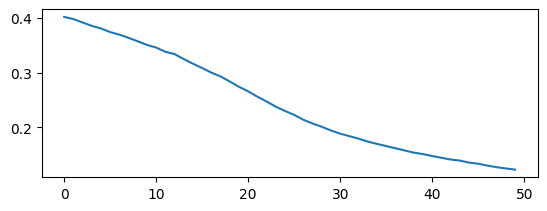

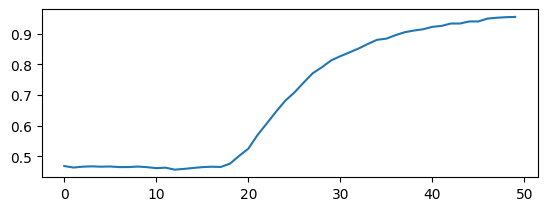

In [12]:
# Hyperparameters
num_iteration = 50
learningRate = 0.1

input_layer = 784 # number of neurones in the input layer (equal to image size)
hidden_layer = 64 # number of neurones in the hidden layer (Custom)
output_layer = 2 # number of neurones in the output layer (equal to the number of possible labels)

# Paramater Initialization
W1 = np.random.rand(input_layer, hidden_layer) - 0.5 # Shape (784, 64)
B1 = np.zeros((1, hidden_layer)) # Shape (1, 64)
W2 = np.random.rand(hidden_layer, output_layer) - 0.5 # Shape (64, 2)
B2 = np.zeros((1, output_layer)) # Shape (1, 2)

# History over epochs
cost_history = []
acc_history = []


# Epoch Loop (mini batch implementation)
print("Start Training Loop:")

for i in range(num_iteration):
    
    # Compute gradients, cost and accuracy over mini batch 
    
    ################## Notations ######################
    # x -> Input Image flatten of shape (1, 784)
    # y* -> One hot label of shape (1, 2)
    # h^ -> Forward prop from Input layer to hidden layer before activation (1, 64) using W1, B1 parm
    # h -> Forward prop from Input layer to hidden layer after tanh activation (1, 64)
    # y^ -> Forward prop from hidden layer to output layer before activation (1, 2) using W2, B2 parm
    # y -> Forward prop from hidden layer to output layer after sigmoid activation (1, 2)
    # E -> Error between y and y* using SSE
    # Acc -> 1 is right prediction 0 otherwise
    # DE/D? -> Partial derivative of the Error regarding parmaters (B2, W2, B1, W1)
    
    
    ################# Forward Prop ######################
    # map batch ([x], [y*]) to ([x], [h^],[y*])
    # map batch ([x], [h^],[y*]) to ([x], [h^], [h], [y*])
    # map batch ([x], [h^], [h], [y*]) to ([x], [h^], [h], [y^], [y*])
    # map batch ([x], [h^], [h], [y^], [y*]) to ([x], [h^], [h], [y^], [y], [y*])
    ################# Backward Prop #####################
    # map batch ([x], [h^], [h], [y^], [y], [y*]) to ([x], [h^], [h], [E], [DE/DB2], [Acc])
    # map batch ([x], [h^], [h], [E], [DE/DB2], [Acc]) to ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc])
    # map batch ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc]) to ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc])
    # map batch ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc]) to ([E], [DE/DB2], [DE/DW2], [DE/DB1], [DE/DW1],[Acc])
    ############### Reduce over the mini batch #########


    gradientCostAcc = train_rdd\
                        .sample(False,0.7)\
                        .map(lambda x: (x[0], preforward(x[0], W1, B1), x[1]))\
                        .map(lambda x: (x[0], x[1], activation(x[1], sigmoid), x[2]))\
                        .map(lambda x: (x[0], x[1], x[2], preforward(x[2], W2, B2), x[3]))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], activation(x[3], sigmoid), x[4]))\
                        .map(lambda x: (x[0], x[1], x[2], sse(x[4], x[5]), derivativeB2(x[4], x[5], x[3], sigmoid_prime), int(np.argmax(x[4]) == np.argmax(x[5]))))\
                        .map(lambda x: (x[0], x[1], x[3], x[4],  derivativeW2(x[2], x[4]) ,x[5]))\
                        .map(lambda x: (x[0], x[2], x[3], x[4],  derivativeB1(x[1],  x[3], W2, sigmoid_prime) ,x[5]))\
                        .map(lambda x: (x[1], x[2], x[3], x[4], derivativeW1(x[0], x[4]) ,x[5], 1)) \
                        .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3], x[4] + y[4], x[5] + y[5], x[6] + y[6]))

    # Cost and Accuarcy of the mini batch
    n = gradientCostAcc[-1] # number of images in the mini batch
    cost = gradientCostAcc[0]/n # Cost over the mini batch
    acc = gradientCostAcc[5]/n # Accuarcy over the mini batch
    
     # Add to history
    cost_history.append(cost)
    acc_history.append(acc)
    

    # Extract gradiends
    DB2 = gradientCostAcc[1]/n
    DW2 = gradientCostAcc[2]/n
    DB1 = gradientCostAcc[3]/n
    DW1 = gradientCostAcc[4]/n
            
    # Update parameter with new learning rate and gradients using Gradient Descent
    B2 -= learningRate * DB2
    W2 -= learningRate * DW2
    B1 -= learningRate * DB1
    W1 -= learningRate * DW1

    # Display performances
    print(f"   Epoch {i+1}/{num_iteration} | Cost: {cost_history[i]} | Acc: {acc_history[i]*100} | Batchsize:{n}")

print("Training end..")

# Plot of cost over epochs
plt.subplot(2, 1, 1)
plt.plot(cost_history)
plt.show()

# Plot of accuracy over epochs
plt.subplot(2, 1, 2)
plt.plot(acc_history)
plt.show()

## Evaluation/Testing

Test Accuracy: 95.89%


Number of misclassifications: 87
Classification Report:
               precision    recall  f1-score   support

           0     0.9827    0.9276    0.9543       980
           1     0.9403    0.9859    0.9626      1135

    accuracy                         0.9589      2115
   macro avg     0.9615    0.9567    0.9585      2115
weighted avg     0.9600    0.9589    0.9588      2115



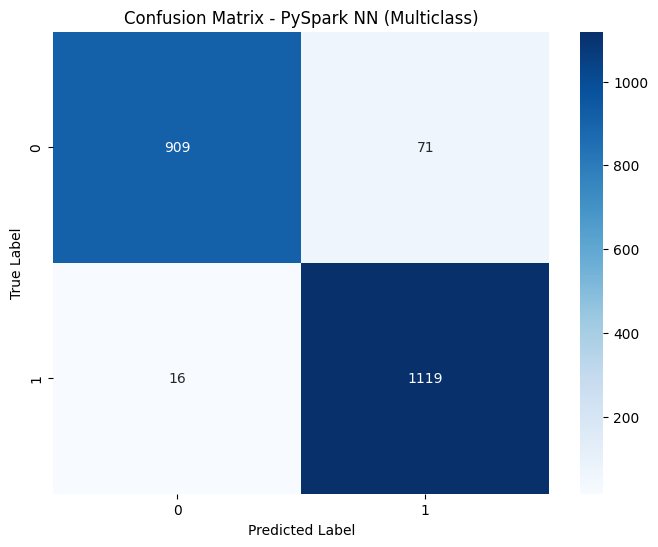

In [13]:
# Function for evaluating accuracy on the test set
def evaluate_model(test_rdd, *params):
    # Each element is (image, label)
    preds_and_trues = test_rdd.map(lambda x: (
        np.argmax(predict(x[0], *params)),   # predicted label
        np.argmax(x[1])                      # true label
    ))
    preds_and_trues_collected = preds_and_trues.collect()
    preds, trues = zip(*preds_and_trues_collected)
    accuracy = np.mean(np.array(preds) == np.array(trues))
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    mistakes = test_rdd.map(lambda x: (
            x[0], np.argmax(predict(x[0], *params)), np.argmax(x[1])
        )).filter(lambda x: x[1] != x[2]).collect()

    print(f"Number of misclassifications: {len(mistakes)}")
    
    # Confusion Matrix
    cm = confusion_matrix(trues, preds)
    print("Classification Report:\n", classification_report(trues, preds, digits=4))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[str(i) for i in range(cm.shape[0])],
                yticklabels=[str(i) for i in range(cm.shape[0])])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - PySpark NN (Multiclass)')
    plt.show()

# For one hidden layer
evaluate_model(test_rdd, W1, B1, W2, B2)

## Inferencing

pred: 0, prob: 0.64 true: 0


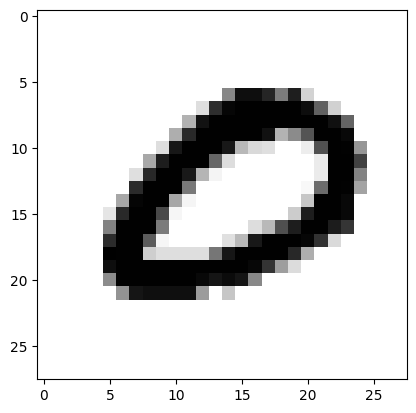

pred: 1, prob: 0.46 true: 1


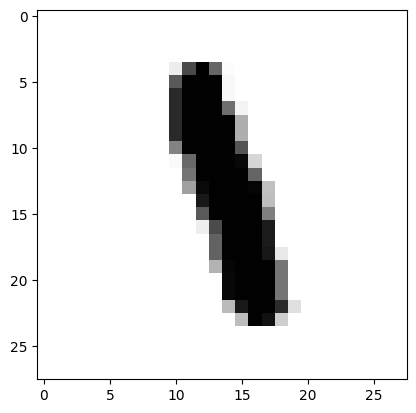

pred: 1, prob: 0.68 true: 1


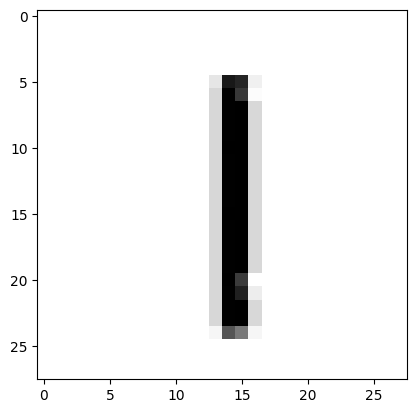

pred: 0, prob: 0.66 true: 0


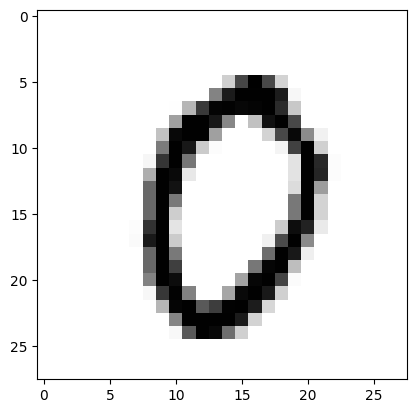

pred: 1, prob: 0.72 true: 1


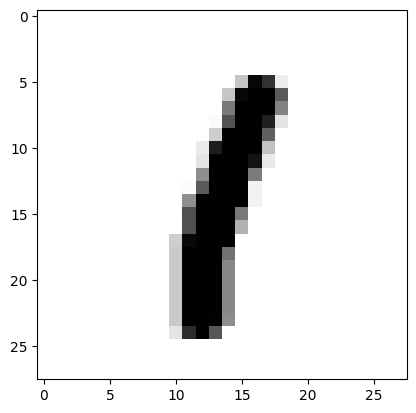

pred: 1, prob: 0.46 true: 0


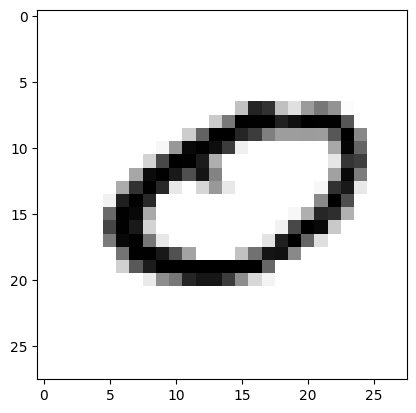

pred: 0, prob: 0.69 true: 0


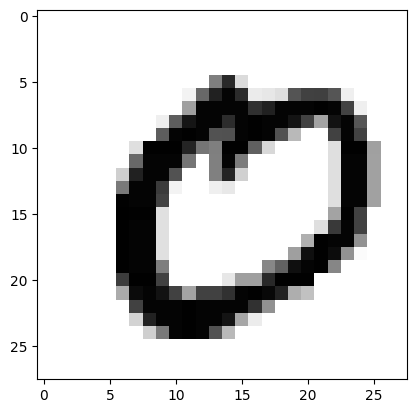

pred: 1, prob: 0.66 true: 1


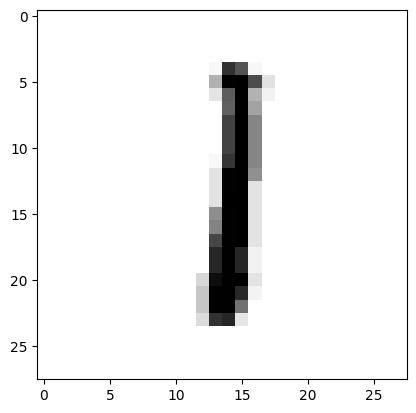

pred: 0, prob: 0.63 true: 0


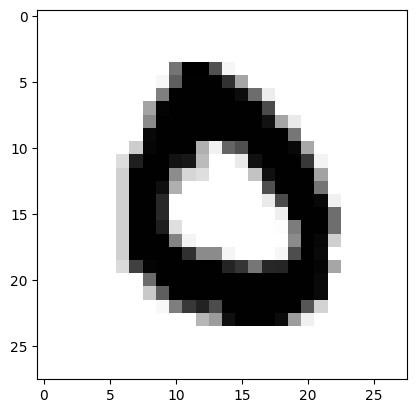

pred: 1, prob: 0.82 true: 1


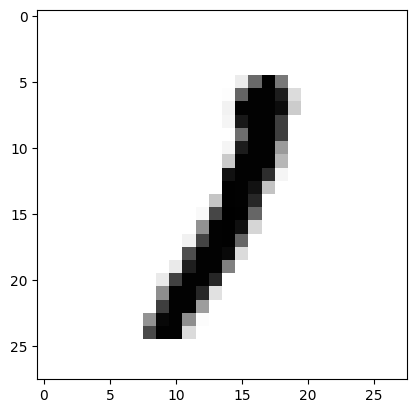

pred: 1, prob: 0.67 true: 1


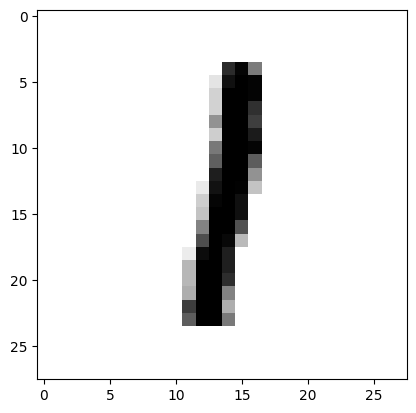

pred: 1, prob: 0.8 true: 1


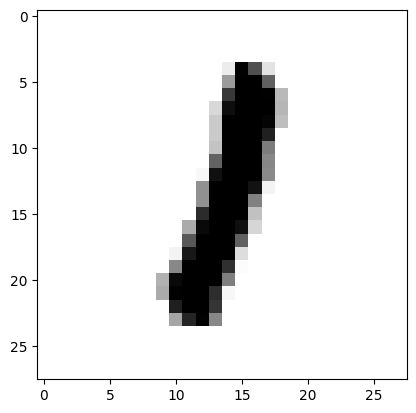

pred: 0, prob: 0.66 true: 0


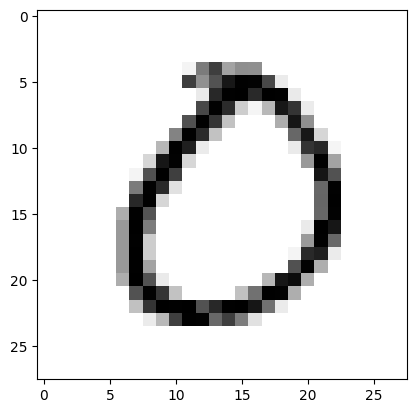

pred: 0, prob: 0.7 true: 0


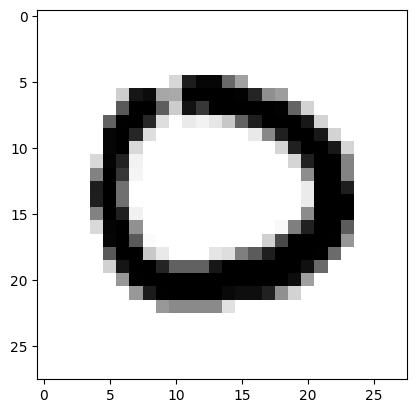

pred: 1, prob: 0.57 true: 1


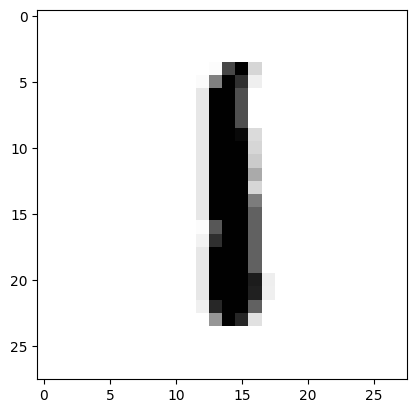

In [14]:
# Display some Images for checking
for image_test in test_rdd.map(lambda x: (x[0], predict(x[0], W1, B1, W2, B2), np.argmax(x[1]))).takeSample(False, 15):
    
    pred = np.argmax(image_test[1])
    print(f'pred: {pred}, prob: {round(image_test[1][0][pred], 2)} true: {image_test[2]}')
    image = np.reshape(image_test[0], (28, 28))
    plt.imshow(image, cmap='binary')
    plt.show()

# Multi Class Classification

Now we will see the multi-class classification approach.

## Unfiltered (Complete) Dataset

In [15]:
train_ds_rdd = x_train.join(y_train).map(lambda x: x[1])
test_ds_rdd = x_test.join(y_test).map(lambda x: x[1])

train_rdd = train_ds_rdd
test_rdd = test_ds_rdd

train_rdd.cache()
test_rdd.cache()
# print(train_rdd.take(1))
print("Trainset size:", train_rdd.count())
print("Testset size:", test_ds_rdd.count())

Trainset size: 60000


Testset size: 10000


## Activation Functions

In [16]:
# # General function to apply any activation function
def activation(x, f):
    return f(x)

def softmax(z):
    e_z = np.exp(z - np.max(z))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

def cross_entropy(y_pred, y_true, eps=1e-8):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.sum(y_true * np.log(y_pred))
    # / y_true.shape[0]

def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

## Forward Propagation

In [17]:
# Compute the layer propagation before activation
def preforward(x, w, b):
    return np.dot(x, w) + b

def predict(x, W1, B1, W2, B2):
    h1 = relu(preforward(x, W1, B1))
    out = softmax(preforward(h1, W2, B2))
    return out

## Backward Propagation

In [18]:
# Compute the derivative of the error regarding B2
def derivativeB2(y_pred, y_true):
    # dL/dB2 = y_pred - y_true
    return y_pred - y_true  # shape: (1, 10)
    
# Compute the derivative of the error regarding W2
def derivativeW2(h, dB2):
    # dL/dW2 = h.T @ (y_pred - y_true)
    return np.dot(h.T, dB2)  # shapes: (64, 1)T @ (1, 10) => (64, 10)
    
# Compute the derivative of the error regarding B1
def derivativeB1(dB2, W2, h_h):
    # dL/dB1 = (y_pred - y_true) @ W2.T * relu'(h_h)
    return np.dot(dB2, W2.T) * relu_prime(h_h)
    
# Compute the derivative of the error regarding W1
def derivativeW1(x, dB1):
    # dL/dW1 = x.T @ dB1
    return np.dot(x.T, dB1)

## Evaluation Metrics

In [19]:
from sklearn.metrics import confusion_matrix

def get_metrics(pred, true):
    pred_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(true, axis=1)
    cm = confusion_matrix(true_labels, pred_labels)
    return cm

## Training

Start Training Loop:


   Epoch 1/50 | Cost: 6.720524886446208 | Acc: 9.540755804101 | Batchsize:5901


   Epoch 2/50 | Cost: 4.931911733893893 | Acc: 9.62800875273523 | Batchsize:5941


   Epoch 3/50 | Cost: 4.027141016094603 | Acc: 12.690776376907763 | Batchsize:6028


   Epoch 4/50 | Cost: 3.545579360267676 | Acc: 16.614420062695924 | Batchsize:6061


   Epoch 5/50 | Cost: 3.3040651240161543 | Acc: 19.358710562414267 | Batchsize:5832


   Epoch 6/50 | Cost: 3.011344378446719 | Acc: 23.2419547079857 | Batchsize:5873


   Epoch 7/50 | Cost: 2.787648826066202 | Acc: 27.00183119693691 | Batchsize:6007


   Epoch 8/50 | Cost: 2.580903467111988 | Acc: 30.811531411431424 | Batchsize:6001


   Epoch 9/50 | Cost: 2.365643126637429 | Acc: 34.36326391259816 | Batchsize:5858


   Epoch 10/50 | Cost: 2.268678295743296 | Acc: 36.86559761944123 | Batchsize:6049


   Epoch 11/50 | Cost: 2.105306792646007 | Acc: 40.702341137123746 | Batchsize:5980


   Epoch 12/50 | Cost: 2.0090130608110233 | Acc: 42.764945652173914 | Batchsize:5888


   Epoch 13/50 | Cost: 1.9487379604739403 | Acc: 43.33870967741936 | Batchsize:6200


   Epoch 14/50 | Cost: 1.8624873263107298 | Acc: 45.204803421615395 | Batchsize:6079


   Epoch 15/50 | Cost: 1.771933092789019 | Acc: 47.81271360218729 | Batchsize:5852


   Epoch 16/50 | Cost: 1.699332093402251 | Acc: 49.33576884755895 | Batchsize:6022


   Epoch 17/50 | Cost: 1.662641937002243 | Acc: 50.45628007300481 | Batchsize:6027


   Epoch 18/50 | Cost: 1.6264341487970202 | Acc: 52.290969899665555 | Batchsize:5980


   Epoch 19/50 | Cost: 1.5364590007833383 | Acc: 53.70680979537068 | Batchsize:5962


   Epoch 20/50 | Cost: 1.5017487377661218 | Acc: 55.00674308833445 | Batchsize:5932


   Epoch 21/50 | Cost: 1.4681788427119862 | Acc: 56.68949390345749 | Batchsize:5987


   Epoch 22/50 | Cost: 1.435078192675704 | Acc: 56.72197764984761 | Batchsize:5906


   Epoch 23/50 | Cost: 1.3863821944358838 | Acc: 57.94829024186823 | Batchsize:5995


   Epoch 24/50 | Cost: 1.348482197032822 | Acc: 59.2887383573243 | Batchsize:5905


   Epoch 25/50 | Cost: 1.2886332944975822 | Acc: 60.650887573964496 | Batchsize:6084


   Epoch 26/50 | Cost: 1.2877858265991324 | Acc: 60.974401321222125 | Batchsize:6055


   Epoch 27/50 | Cost: 1.2843041507994486 | Acc: 60.83347169184792 | Batchsize:6023


   Epoch 28/50 | Cost: 1.1995378493990472 | Acc: 63.6238374095763 | Batchsize:5806


   Epoch 29/50 | Cost: 1.2231596499731803 | Acc: 62.02489068281197 | Batchsize:5946


   Epoch 30/50 | Cost: 1.1856243363616992 | Acc: 64.40480160053352 | Batchsize:5998


   Epoch 31/50 | Cost: 1.1645191583881396 | Acc: 63.89442231075697 | Batchsize:6024


   Epoch 32/50 | Cost: 1.163103729840387 | Acc: 64.09440910612655 | Batchsize:5974


   Epoch 33/50 | Cost: 1.1559849046567428 | Acc: 65.47457627118644 | Batchsize:5900


   Epoch 34/50 | Cost: 1.0918424828508635 | Acc: 66.61671661671662 | Batchsize:6006


   Epoch 35/50 | Cost: 1.0695699269175427 | Acc: 66.61613609567122 | Batchsize:5937


   Epoch 36/50 | Cost: 1.0556441221993704 | Acc: 67.90060851926978 | Batchsize:5916


   Epoch 37/50 | Cost: 1.087892617889408 | Acc: 67.2950681703417 | Batchsize:5941


   Epoch 38/50 | Cost: 1.0363458853694711 | Acc: 68.69025658225726 | Batchsize:5963


   Epoch 39/50 | Cost: 1.0767273115536833 | Acc: 67.75818639798489 | Batchsize:5955


   Epoch 40/50 | Cost: 1.0470518478873898 | Acc: 67.95020746887967 | Batchsize:6025


   Epoch 41/50 | Cost: 0.9945188659164071 | Acc: 69.70040485829959 | Batchsize:6175


   Epoch 42/50 | Cost: 0.9995248102040553 | Acc: 69.90710019907101 | Batchsize:6028


   Epoch 43/50 | Cost: 0.9631067635476592 | Acc: 70.12578616352201 | Batchsize:6042


   Epoch 44/50 | Cost: 0.9776143704350556 | Acc: 70.40747028862478 | Batchsize:5890


   Epoch 45/50 | Cost: 0.9615247451335376 | Acc: 70.49840577278067 | Batchsize:5959


   Epoch 46/50 | Cost: 0.9648620043881804 | Acc: 70.16277898976338 | Batchsize:5959


   Epoch 47/50 | Cost: 0.9460012585897576 | Acc: 70.58236272878536 | Batchsize:6010


   Epoch 48/50 | Cost: 0.9086687178300671 | Acc: 71.12481739977277 | Batchsize:6161


   Epoch 49/50 | Cost: 0.9179217987609367 | Acc: 71.30895420369104 | Batchsize:5852


   Epoch 50/50 | Cost: 0.9130932337727273 | Acc: 72.05218263923733 | Batchsize:5979
Training end..


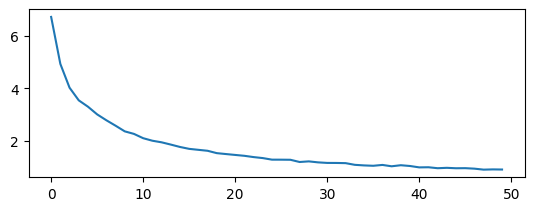

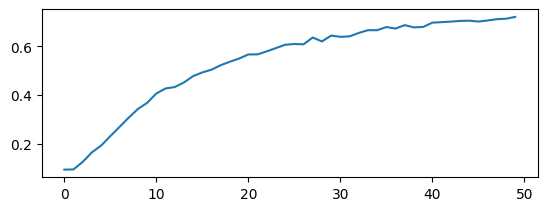

In [20]:
# Hyperparameters
num_iteration = 50
learningRate = 0.1

input_layer = 784 # number of neurones in the input layer (equal to image size)
hidden_layer = 64 # number of neurones in the hidden layer (Custom)
output_layer = 10 # number of neurones in the output layer (equal to the number of possible labels)

# Paramater Initialization
W1 = np.random.rand(input_layer, hidden_layer) - 0.5 # Shape (784, 64)
B1 = np.zeros((1, hidden_layer)) # Shape (1, 64)
W2 = np.random.rand(hidden_layer, output_layer) - 0.5 # Shape (64, 10)
B2 = np.zeros((1, output_layer)) # Shape (1, 10)

# History over epochs
cost_history = []
acc_history = []


# Epoch Loop (mini batch implementation)
print("Start Training Loop:")

for i in range(num_iteration):

    # Compute gradients, cost and accuracy over mini batch

    ################## Notations ######################
    # x -> Input Image flatten of shape (1, 784)
    # y* -> One hot label of shape (1, 2)
    # h^ -> Forward prop from Input layer to hidden layer before activation (1, 64) using W1, B1 parm
    # h -> Forward prop from Input layer to hidden layer after tanh activation (1, 64)
    # y^ -> Forward prop from hidden layer to output layer before activation (1, 2) using W2, B2 parm
    # y -> Forward prop from hidden layer to output layer after sigmoid activation (1, 2)
    # E -> Error between y and y* using SSE
    # Acc -> 1 is right prediction 0 otherwise
    # DE/D? -> Partial derivative of the Error regarding parmaters (B2, W2, B1, W1)


    ################# Forward Prop ######################
    # map batch ([x], [y*]) to ([x], [h^],[y*])
    # map batch ([x], [h^],[y*]) to ([x], [h^], [h], [y*])
    # map batch ([x], [h^], [h], [y*]) to ([x], [h^], [h], [y^], [y*])
    # map batch ([x], [h^], [h], [y^], [y*]) to ([x], [h^], [h], [y^], [y], [y*])
    ################# Backward Prop #####################
    # map batch ([x], [h^], [h], [y^], [y], [y*]) to ([x], [h^], [h], [E], [DE/DB2], [Acc])
    # map batch ([x], [h^], [h], [E], [DE/DB2], [Acc]) to ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc])
    # map batch ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc]) to ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc])
    # map batch ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc]) to ([E], [DE/DB2], [DE/DW2], [DE/DB1], [DE/DW1],[Acc])
    ############### Reduce over the mini batch #########


    gradientCostAcc = train_rdd\
                        .sample(False,0.1)\
                        .map(lambda x: (x[0], preforward(x[0], W1, B1), x[1]))\
                        .map(lambda x: (x[0], x[1], activation(x[1], relu), x[2]))\
                        .map(lambda x: (x[0], x[1], x[2], preforward(x[2], W2, B2), x[3]))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], activation(x[3], softmax), x[4]))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], cross_entropy(x[4], x[5]), derivativeB2(x[4], x[5]), int(np.argmax(x[4]) == np.argmax(x[5]))))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], derivativeW2(x[2], x[7])))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], derivativeB1(x[7], W2, x[1])))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], derivativeW1(x[0], x[10]), 1)) \
                        .reduce(lambda x, y: tuple(a + b if isinstance(a, np.ndarray) else a + b for a, b in zip(x, y)))

    # print(gradientCostAcc)

    #
    # Cost and Accuarcy of the mini batch
    n = gradientCostAcc[-1] # number of images in the mini batch
    cost = gradientCostAcc[6]/n # Cost over the mini batch
    acc = gradientCostAcc[8]/n # Accuarcy over the mini batch

     # Add to history
    cost_history.append(cost)
    acc_history.append(acc)


    # Extract gradiends
    DB2 = gradientCostAcc[7]/n
    DW2 = gradientCostAcc[9]/n
    DB1 = gradientCostAcc[10]/n
    DW1 = gradientCostAcc[11]/n

    # Update parameter with new learning rate and gradients using Gradient Descent
    B2 -= learningRate * DB2
    W2 -= learningRate * DW2
    B1 -= learningRate * DB1
    W1 -= learningRate * DW1

    # Display performances
    print(f"   Epoch {i+1}/{num_iteration} | Cost: {cost_history[i]} | Acc: {acc_history[i]*100} | Batchsize:{n}")

print("Training end..")

# Plot of cost over epochs
plt.subplot(2, 1, 1)
plt.plot(cost_history)
plt.show()

# Plot of accuracy over epochs
plt.subplot(2, 1, 2)
plt.plot(acc_history)
plt.show()

## Evaluation/Testing

Test Accuracy: 72.42%


Number of misclassifications: 2758
Classification Report:
               precision    recall  f1-score   support

           0     0.8008    0.8367    0.8184       980
           1     0.8657    0.9145    0.8895      1135
           2     0.7273    0.6899    0.7081      1032
           3     0.7136    0.7129    0.7132      1010
           4     0.7450    0.7138    0.7291       982
           5     0.5820    0.5448    0.5628       892
           6     0.7667    0.8027    0.7843       958
           7     0.7706    0.7383    0.7541      1028
           8     0.5635    0.5832    0.5732       974
           9     0.6578    0.6630    0.6604      1009

    accuracy                         0.7242     10000
   macro avg     0.7193    0.7200    0.7193     10000
weighted avg     0.7229    0.7242    0.7232     10000



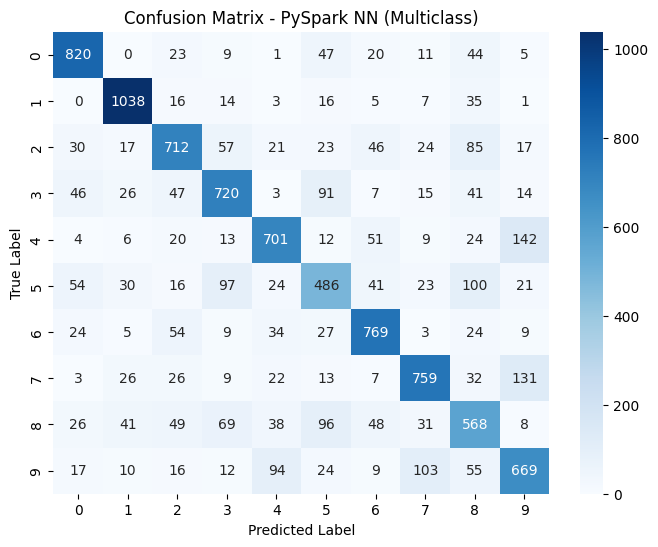

In [21]:
# Function for evaluating accuracy on the test set
def evaluate_model(test_rdd, *params):
    # Each element is (image, label)
    preds_and_trues = test_rdd.map(lambda x: (
        np.argmax(predict(x[0], *params)),   # predicted label
        np.argmax(x[1])                      # true label
    ))
    preds_and_trues_collected = preds_and_trues.collect()
    preds, trues = zip(*preds_and_trues_collected)
    accuracy = np.mean(np.array(preds) == np.array(trues))
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    mistakes = test_rdd.map(lambda x: (
            x[0], np.argmax(predict(x[0], *params)), np.argmax(x[1])
        )).filter(lambda x: x[1] != x[2]).collect()

    print(f"Number of misclassifications: {len(mistakes)}")
    
    # Confusion Matrix
    cm = confusion_matrix(trues, preds)
    print("Classification Report:\n", classification_report(trues, preds, digits=4))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[str(i) for i in range(cm.shape[0])],
                yticklabels=[str(i) for i in range(cm.shape[0])])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - PySpark NN (Multiclass)')
    plt.show()

# For one hidden layer
evaluate_model(test_rdd, W1, B1, W2, B2)

# For two hidden layers
# evaluate_model(test_rdd, W1, B1, W2, B2, W3, B3)

## Inferencing

pred: 2, prob: 0.94 true: 2


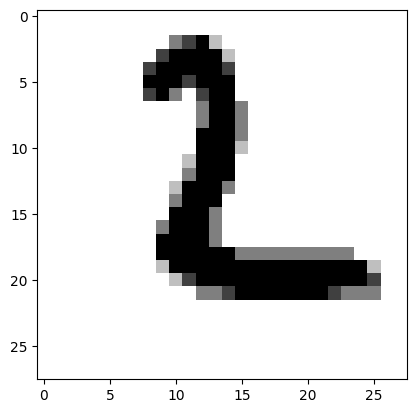

pred: 3, prob: 0.89 true: 3


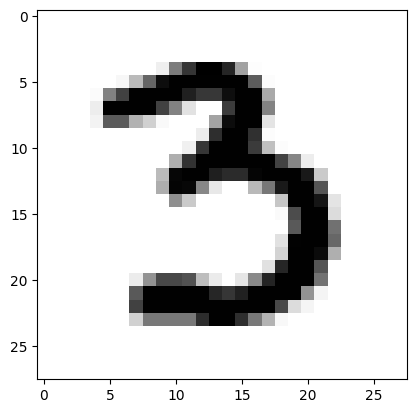

pred: 4, prob: 0.34 true: 9


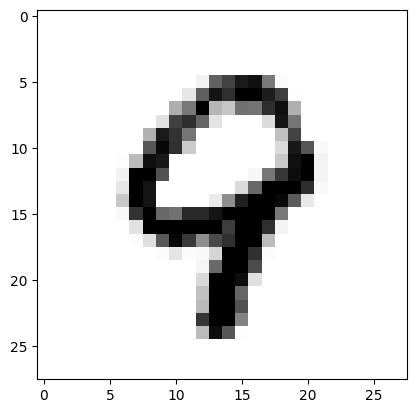

pred: 9, prob: 0.94 true: 9


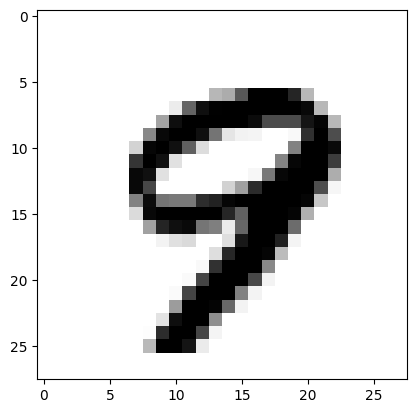

pred: 8, prob: 0.48 true: 9


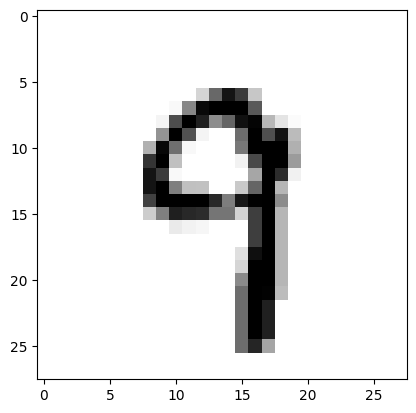

pred: 8, prob: 0.52 true: 2


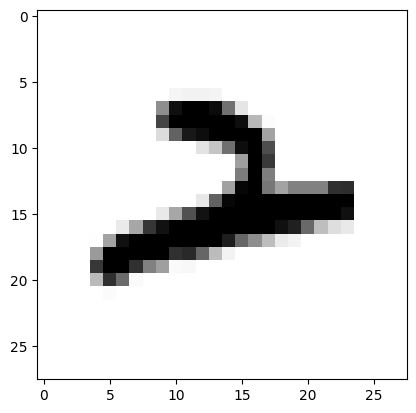

pred: 1, prob: 0.52 true: 1


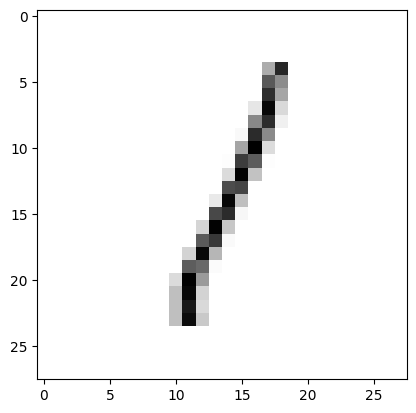

pred: 3, prob: 0.67 true: 3


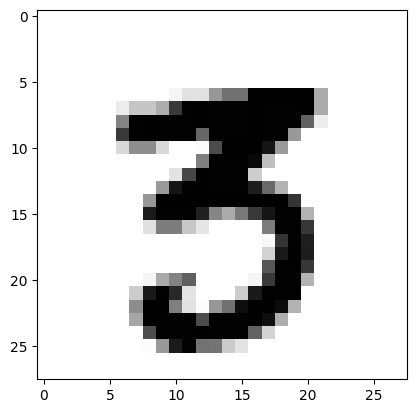

pred: 2, prob: 0.51 true: 3


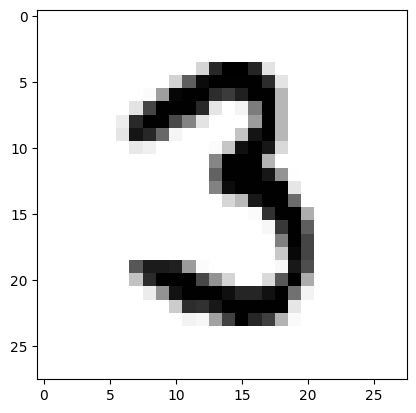

pred: 0, prob: 0.61 true: 0


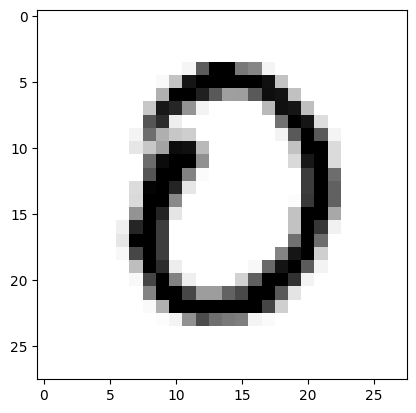

pred: 8, prob: 0.59 true: 8


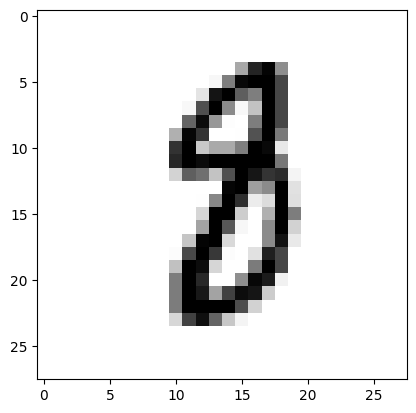

pred: 7, prob: 0.59 true: 3


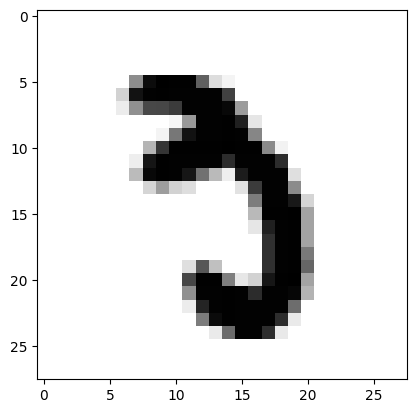

pred: 6, prob: 0.56 true: 6


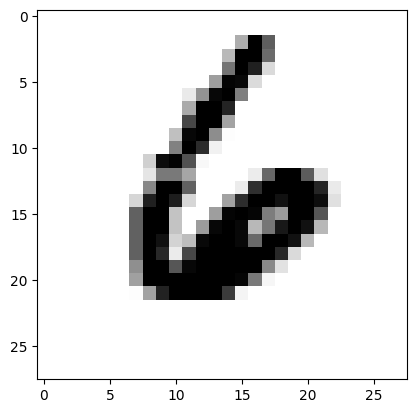

pred: 7, prob: 0.99 true: 7


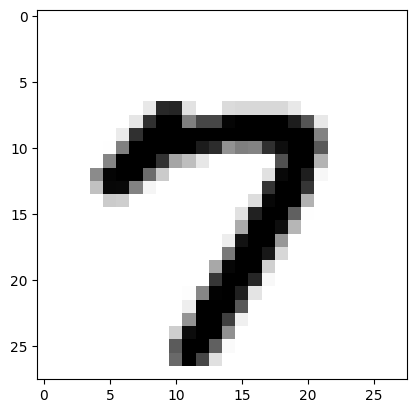

pred: 3, prob: 0.96 true: 3


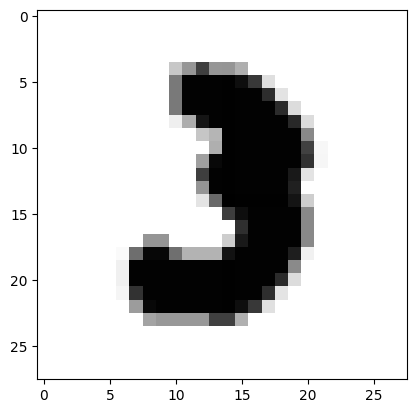

In [22]:
# Display some Images for checking
for image_test in test_rdd.map(lambda x: (x[0], predict(x[0], W1, B1, W2, B2), np.argmax(x[1]))).takeSample(False, 15):

    pred = np.argmax(image_test[1])
    print(f'pred: {pred}, prob: {round(image_test[1][0][pred], 2)} true: {image_test[2]}')
    image = np.reshape(image_test[0], (28, 28))
    plt.imshow(image, cmap='binary')
    plt.show()